### Utilizing Random Forest model to train from 2077-2081 overall company data

dataset: dataset\data_in_million.csv
Here data in billion is compressed into million.
Visualization is done
Scaling is used
Coorelation is measured
performance metrics: R^2 score, RMSE, MSE, MAE

In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load dataset
data = pd.read_csv(r"dataset\data_in_million.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [3]:

# data visualization using plotly

import plotly.graph_objs as go
import plotly.offline as pyo

df_sales = pd.read_csv(r"dataset\data_in_million.csv")

df_sales.columns = ['date','sales']

df_sales[['Year', 'Month']] = df_sales['date'].str.split('-', expand=True)
df_sales['Year'] = df_sales['Year'].astype(int)
df_sales['Month'] = df_sales['Month'].astype(int)
nepali_months_fiscal_order = {
    4: "Shrawan", 5: "Bhadra", 6: "Asoj", 7: "Kartik",
    8: "Mangsir", 9: "Poush", 10: "Magh", 11: "Falgun",
    12: "Chaitra", 1: "Baishakh", 2: "Jestha", 3: "Ashadh"
}

df_sales['Month_Name'] = df_sales['Month'].map(nepali_months_fiscal_order)


df_sales['Fiscal_Year'] = df_sales.apply(lambda row: 
                                         f"{row['Year']}-{row['Year']+1}" if row['Month'] >= 4 
                                         else f"{row['Year']-1}-{row['Year']}", axis=1)

df_sales['Month_Order'] = df_sales['Month'].apply(lambda x: list(nepali_months_fiscal_order.keys()).index(x))

df_sales = df_sales.sort_values(by=['Fiscal_Year', 'Month_Order'])

fig = go.Figure()

fiscal_years = df_sales['Fiscal_Year'].unique()

for fy in fiscal_years:
    df_fy = df_sales[df_sales['Fiscal_Year'] == fy]
    fig.add_trace(go.Scatter(
        x=df_fy['Month_Name'], 
        y=df_fy['sales'], 
        mode='lines+markers',
        name=f'Fiscal Year {fy}',
        line=dict(shape='spline')  
    ))

fig.update_layout(
    title="Sales Trend by Fiscal Year",
    xaxis_title="Nepali Month",
    yaxis_title="Sales",
    xaxis=dict(categoryorder='array', categoryarray=list(nepali_months_fiscal_order.values())),
    template="plotly_dark",
    hovermode="x unified"
)

pyo.iplot(fig)


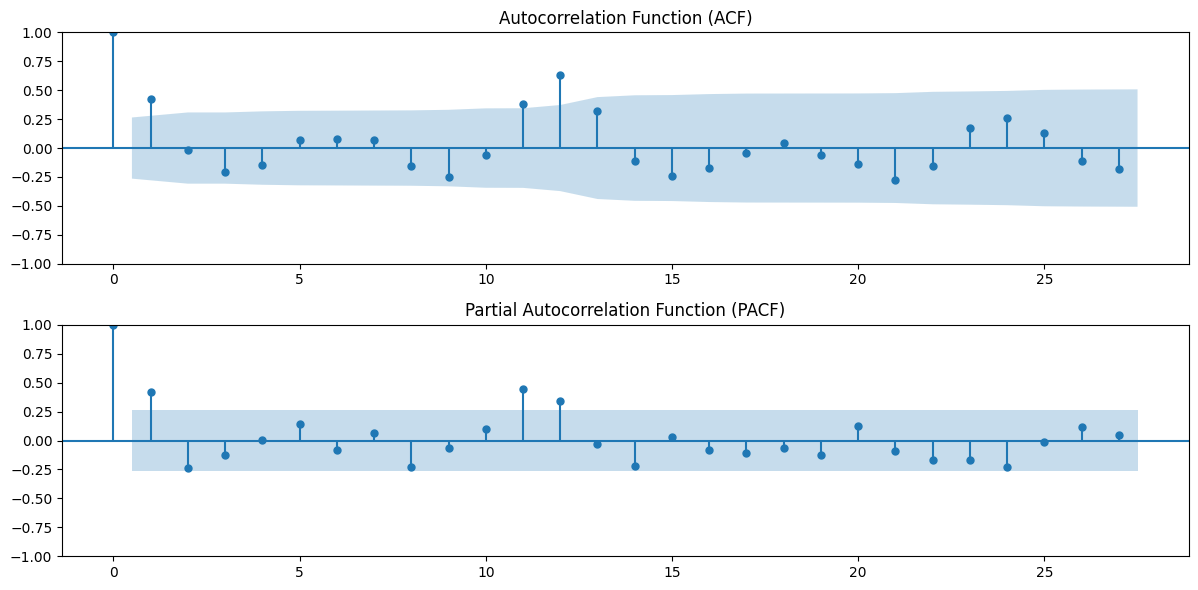

In [4]:
# analyzing auto_correlation and partial auto correlation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Calculate the ACF and PACF

acf_values = acf(data["sales"], nlags=27, fft=False)
pacf_values = pacf(data["sales"], nlags=27)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(data["sales"], lags=27, ax=plt.gca())  
plt.title("Autocorrelation Function (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(data["sales"], lags=27, ax=plt.gca())  
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()




In [5]:
print(f"The ACF values are : \n{acf_values}")


The ACF values are : 
[ 1.          0.42180933 -0.0172801  -0.20512494 -0.14849627  0.07230753
  0.07904957  0.07392186 -0.15235237 -0.24611023 -0.0641271   0.37916136
  0.63015029  0.31708569 -0.11229154 -0.23740929 -0.17218182 -0.04622351
  0.04203564 -0.05709468 -0.13400492 -0.27906906 -0.1554262   0.17631208
  0.25727764  0.13210645 -0.11592243 -0.18058989]


In [6]:

print(f"The PACF values are : \n{pacf_values}")
a= pacf_values

The PACF values are : 
[ 1.00000000e+00  4.29620614e-01 -2.48343839e-01 -1.31543001e-01
  3.26233840e-03  1.56970411e-01 -9.27428930e-02  7.86396110e-02
 -2.77493258e-01 -7.87169554e-02  1.27439176e-01  5.94846251e-01
  5.82540661e-01  8.18726276e-02 -6.80002734e-01 -7.76143138e-01
 -1.29376157e+00  1.31637619e+00  5.90221334e+00 -1.17935976e+00
  7.21949685e-01  7.06434678e-01 -3.45204391e-01 -2.49373212e+00
  8.09874239e-01 -4.70507511e+00 -9.45723824e-01 -1.04526502e+00]


In [7]:

pacf_values

array([ 1.00000000e+00,  4.29620614e-01, -2.48343839e-01, -1.31543001e-01,
        3.26233840e-03,  1.56970411e-01, -9.27428930e-02,  7.86396110e-02,
       -2.77493258e-01, -7.87169554e-02,  1.27439176e-01,  5.94846251e-01,
        5.82540661e-01,  8.18726276e-02, -6.80002734e-01, -7.76143138e-01,
       -1.29376157e+00,  1.31637619e+00,  5.90221334e+00, -1.17935976e+00,
        7.21949685e-01,  7.06434678e-01, -3.45204391e-01, -2.49373212e+00,
        8.09874239e-01, -4.70507511e+00, -9.45723824e-01, -1.04526502e+00])

#### Feature Engineering
1. Lags and Rolling mean are defined
2. Lags are calculated from ACF and PACF
3. Only using 12 month ago feature as an input

In [8]:
# Feature Engineering
data['month'] = data.index.month
data['year'] = data.index.year
data['dayofweek'] = data.index.dayofweek
# data['lag_1']=data['sales'].shift(1)
# data['lag_11']=data['sales'].shift(11)

data['lag_12'] = data['sales'].shift(12)
# data['lag_13']=data['sales'.shift(13)]


data['rolling_mean_3'] = data['sales'].rolling(window=3).mean()
data['rolling_std_6'] = data['sales'].rolling(window=6).std()
data.dropna(inplace=True)


In [9]:
# Train-Test Split 80% and 20%
X = data.drop(columns=['sales'])
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
print(f"The length of training data is : {len(X_train)} and the length of testing data is : {len(X_test)}")

The length of training data is : 34 and the length of testing data is : 9


In [11]:
X_test

,month,year,dayofweek,lag_12,rolling_mean_3,rolling_std_6
date,,,,,,
2081-02-01,2,2081,5,3351521.109,1.861335e+06,372821.453803
2081-03-01,3,2081,5,456534.929,1.523606e+06,578225.510853
2081-04-01,4,2081,1,315444.544,9.997818e+05,675808.330313
2081-05-01,5,2081,3,777364.928,7.446697e+05,678903.886500
2081-06-01,6,2081,6,1803652.032,1.088672e+06,680225.704622
2081-07-01,7,2081,1,1088242.622,1.306185e+06,547452.587467
2081-08-01,8,2081,4,1673803.337,1.392418e+06,433020.468981
2081-09-01,9,2081,0,1417110.898,1.308267e+06,343416.409725
2081-10-01,10,2081,2,1109086.277,1.240834e+06,192137.972934


In [12]:
# Standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [13]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=6, random_state=42, n_jobs=-1, verbose=1)
rf_model.fit(X_train_scaled, y_train_scaled)
yran_pred_scaled = rf_model.predict(X_test_scaled)
yran_pred = scaler_y.inverse_transform(yran_pred_scaled.reshape(-1, 1)).flatten()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [14]:
# from sklearn.model_selection import GridSearchCV
# # Hyperparameter Tuning
# param_grid = {
#     "n_estimators": [500, 1000, 1500],
#     "max_depth": [5, 10, 15],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4]

# }


# #Hyperparameter Tuning and cross-validation using Grid Search Technique
# rf = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=True)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# rf=RandomForestRegressor(random_state=42,n_jobs=-1,verbose=True)
# #
# best_rf = grid_search.best_estimator_

In [15]:
y_pred_scaled = rf_model.predict(X_test_scaled)
yran_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [16]:
# Random Forest Metrics
mae_rf = mean_absolute_error(y_test, yran_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, yran_pred))
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest MAE: 79728.14
Random Forest RMSE: 112815.75


In [17]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, yran_pred)
print(f"Random Forest R² Score: {r2_rf:.4f}")


Random Forest R² Score: 0.9284


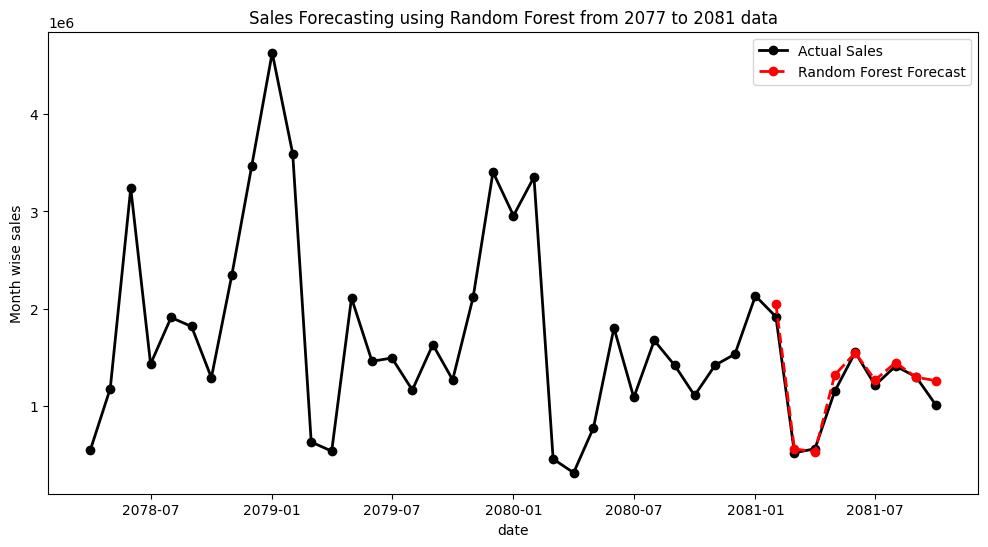

In [25]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["sales"], label="Actual Sales", color="black", linewidth=2, marker='o')
plt.plot(X_test.index, yran_pred, label="Random Forest Forecast", color="red", linestyle="dashed", linewidth=2, marker='o')

plt.title("Sales Forecasting using Random Forest from 2077 to 2081 data")
plt.xlabel("date")
plt.ylabel("Month wise sales")
plt.legend()
plt.show()



In [ ]:
xgb_model=xgb.XGBRegressor(objective='reg:squarederror', n_estimator=1000, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="rmse")
xgb_model.fit(X_train_scaled, y_train_scaled, eval_set=[(X_test_scaled. y_test_scaled)], verbose=True)
yxb_pred_scaled = xgb_model.predict(X_test_scaled)
yxg_pred = 

### XG Boost

In [19]:

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="rmse")
xgb_model.fit(X_train_scaled, y_train_scaled, eval_set=[(X_test_scaled, y_test_scaled)], verbose=True)
yxg_pred_scaled = xgb_model.predict(X_test_scaled)
yxg_pred = scaler_y.inverse_transform(yxg_pred_scaled.reshape(-1, 1)).flatten()


[0]	validation_0-rmse:0.70645
[1]	validation_0-rmse:0.68132
[2]	validation_0-rmse:0.65685
[3]	validation_0-rmse:0.63383
[4]	validation_0-rmse:0.60984
[5]	validation_0-rmse:0.58252
[6]	validation_0-rmse:0.56212
[7]	validation_0-rmse:0.54020
[8]	validation_0-rmse:0.52003
[9]	validation_0-rmse:0.49515
[10]	validation_0-rmse:0.47675
[11]	validation_0-rmse:0.45496
[12]	validation_0-rmse:0.43817
[13]	validation_0-rmse:0.42150
[14]	validation_0-rmse:0.40928
[15]	validation_0-rmse:0.40662
[16]	validation_0-rmse:0.39049
[17]	validation_0-rmse:0.37813
[18]	validation_0-rmse:0.36744
[19]	validation_0-rmse:0.35399
[20]	validation_0-rmse:0.34090
[21]	validation_0-rmse:0.32850
[22]	validation_0-rmse:0.31451
[23]	validation_0-rmse:0.30099
[24]	validation_0-rmse:0.28718
[25]	validation_0-rmse:0.27835
[26]	validation_0-rmse:0.26502
[27]	validation_0-rmse:0.25797
[28]	validation_0-rmse:0.24799
[29]	validation_0-rmse:0.23959
[30]	validation_0-rmse:0.23055
[31]	validation_0-rmse:0.22117
[32]	validation_0-

In [20]:
# XGBoost Metrics
mae_xgb = mean_absolute_error(y_test, yxg_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, yxg_pred))
print(f"XGBoost MAE 2077-2081: {mae_xgb:.2f}")
print(f"XGBoost RMSE 2077-2081: {rmse_xgb:.2f}")


XGBoost MAE 2077-2081: 78855.10
XGBoost RMSE 2077-2081: 114682.64


In [21]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, yxg_pred)
print(f"XG boost R² Score 2077-2081: {r2_rf:.4f}")

XG boost R² Score 2077-2081: 0.9260


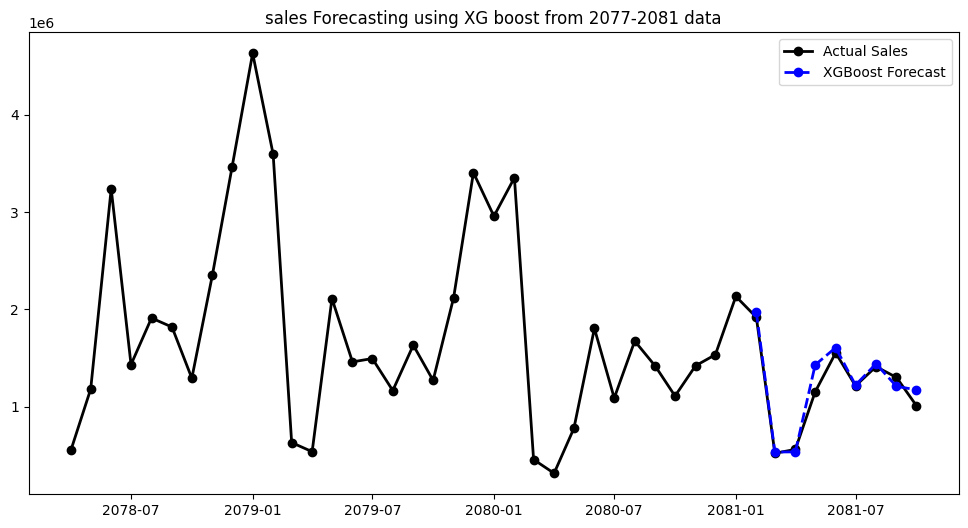

In [24]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["sales"], label="Actual Sales", color="black", linewidth=2, marker='o')

plt.plot(X_test.index, yxg_pred, label="XGBoost Forecast", color="blue", linestyle="dashed", linewidth=2, marker='o')
plt.title("sales Forecasting using XG boost from 2077-2081 data")
plt.legend()
plt.show()



### Comparision from Random Forest and XG boost from 2077-2081 data and Visualizing them

Random Forest                           XG Boost
1. MAE random: 79728.14   ----------------             1. MAE xgb: 78855.10
2. RMSE random: 112815.75 ----------------            2. RMSE xgb: 114682.64
3. R2 score random: 0.9284-----------------             3. R2_score xgb: 0.9260

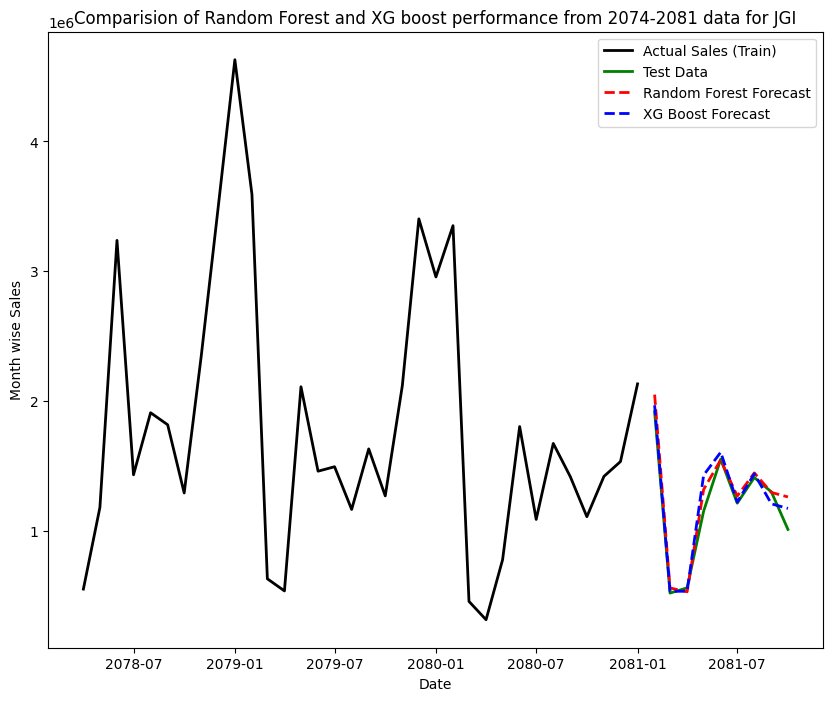

In [23]:
plt.figure(figsize=(10,8))
plt.plot(data.index[:-(len(X_test))], data["sales"][:-(len(X_test))], label="Actual Sales (Train)", color="black", linestyle="solid", linewidth=2)
plt.plot(data.index[-(len(X_test)):], data["sales"][-(len(X_test)):], label="Test Data", color="green", linestyle="solid", linewidth=2)
plt.plot(X_test.index, yran_pred, label="Random Forest Forecast", color="red", linestyle="dashed", linewidth=2 )
plt.plot(X_test.index, yxg_pred, label="XG Boost Forecast", color="blue", linestyle="dashed", linewidth=2)
plt.title("Comparision of Random Forest and XG boost performance from 2074-2081 data for JGI")
plt.xlabel("Date")
plt.ylabel("Month wise Sales")
plt.legend()
plt.show()